# Partial Wave Analysis of $\eta\pi$

In [ ]:
using InstantiateFromURL
github_project("mmikhasenko/Introduction2AmplitudeAnalysis")

In [115]:
using TypedTables
using DelimitedFiles
using Plots
using PartialWaveFunctions
using Cuba
using QuadGK
using Optim
using Test
using ForwardDiff

## Load data

In [2]:
data = let
    M = readdlm(joinpath("data","data_metapi_costheta_phi.txt"))
    Table(mηπ=M[:,1], cosθ=M[:,2], ϕ=M[:,3])
end

Table with 3 columns and 301509 rows:
      mηπ       cosθ        ϕ
    ┌────────────────────────────────
 1  │ 0.746092  0.195056    0.844116
 2  │ 0.746093  -0.377158   1.44063
 3  │ 0.749001  0.124863    2.60888
 4  │ 0.747063  -0.301097   1.7275
 5  │ 0.743173  0.321269    2.24002
 6  │ 0.740242  -0.0218408  -0.660148
 7  │ 0.738281  -0.701538   0.470193
 8  │ 0.747063  -0.845097   1.08823
 9  │ 0.742196  -0.235953   1.66328
 10 │ 0.742685  0.188018    0.755586
 11 │ 0.740242  0.0750287   -2.1202
 12 │ 0.742196  0.209545    0.783272
 13 │ 0.742197  0.298567    -1.11891
 14 │ 0.740241  -0.316157   -1.76627
 15 │ 0.743172  0.471116    2.48357
 16 │ 0.743173  -0.67887    2.67181
 17 │ 0.74122   -0.0153329  1.98629
 18 │ 0.740242  -0.72464    -1.12899
 19 │ 0.738281  -0.804498   -1.30071
 20 │ 0.743173  0.0726688   0.985721
 21 │ 0.742197  0.542215    -1.94304
 22 │ 0.744147  -0.398314   0.848841
 23 │ 0.747063  -0.202187   0.548641
 ⋮  │    ⋮          ⋮           ⋮

## Build the model

The basis function are the orthonormal rotation functions
$$
\Psi_{LM}(\Omega) = \sqrt{\frac{2L+1}{2\pi}}d_{M0}^{L}(\theta)\,\sin(M\phi)
$$

In [3]:
ΨLM(cosθ,ϕ,L,M) = sqrt((2L+1)/(4π))*wignerd(L,M,0,cosθ)*sin(M*ϕ)*sqrt(2)

ΨLM (generic function with 1 method)

One can check orthogonality of the functions

In [4]:
let M=1, L=5
    4π*cuhre((x,f)->f[1] = abs2(ΨLM(2x[1]-1,π*(2*x[2]-1),L,M)),2,1).integral[1]
end

0.9999991627159617

In [300]:
const LMs = NamedTuple{(:L,:M)}.([(1,1),(2,1),(4,1)])

3-element Array{NamedTuple{(:L, :M),Tuple{Int64,Int64}},1}:
 (L = 1, M = 1)
 (L = 2, M = 1)
 (L = 4, M = 1)

The model of the amplitude is a truncated series of the partial waves.

We truncate at $L<5$ and $M<2$. $L=0$ and $M=0$ are forbidden by the selection rule (*)

In [180]:
model(cosθ,ϕ; pars) = sum(c*ΨLM(cosθ,ϕ,L,M) for (c,(L,M)) in zip(pars, LMs))

model (generic function with 1 method)

In [182]:
@test model(0.1,0.1; pars=rand(length(LMs)) + 1im*rand(length(LMs))) != 0.0

Test Passed

Plot the model in $\cos\theta \times \phi$ coordinates

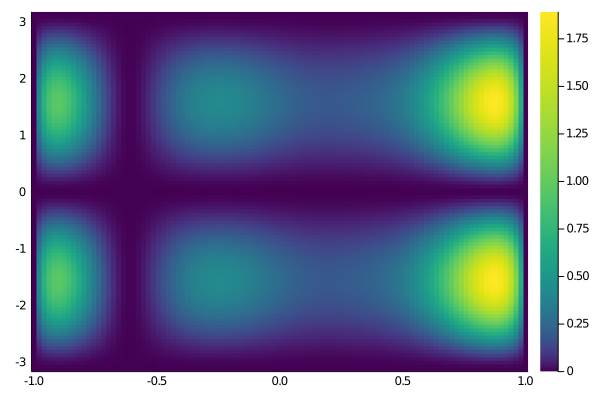

In [237]:
let pars = rand(length(LMs)) + 1im*rand(length(LMs))
    cosθv = range(-1,1,length=100)
    ϕv = range(-π,π,length=100)
    calv = [model(cosθ,ϕ; pars=pars) for ϕ in ϕv, cosθ in cosθv]
    heatmap(cosθv, ϕv, abs2.(calv), lab="",
        color=cgrad(:viridis, scale=:exp))
end

In [184]:
ellh(;data, pars) = -sum(log, abs2(model(cosθ,ϕ; pars=pars)) for (_,cosθ,ϕ) in data) + sum(abs2,pars)

ellh (generic function with 1 method)

In [185]:
@time ellh(;data=data, pars=rand(length(LMs)) + 1im*rand(length(LMs)))

  0.194480 seconds (85.68 k allocations: 4.552 MiB)


639526.1232728338

In [ ]:
let mηπ_lims = (1.5,1.54)
    ldata = filter(x->1.5<x.mηπ<1.54, data)
    Np = length(LMs)
    fold(x) = x[1:Np] + 1im .* x[(Np+1):2Np]
    init_pars = fold(2rand(2Np).-1) # get random starting parameters
    init_pars .*= sqrt(length(data)/sum(abs2,init_pars)) # normalize
    #
    f(x) = ellh(;data=ldata, pars=x)
    f′(x) = fold(ForwardDiff.gradient(p->f(fold(p)), vcat(real(x), imag(x))))
    f′!(stor,x) = copyto!(stor,f′(x))
    #
    Optim.optimize(f, f′!, init_pars, BFGS(),
                Optim.Options(show_trace = true))
end

Check if the constraint is fulfilled

In [269]:
sum(abs2,Optim.minimizer(ans))

6206.999899549879

## Mass production:
 - create a settings file several fit attempts from random starting points

In [289]:
function fit_data!(settings)
    ldata = settings["data"]
    _Natt = settings["Natt"]
    #
    Np = length(LMs)
    fold(x) = x[1:Np]+x[Np+1:2Np]
    #
    f(x) = ellh(;data=ldata, pars=x)
    f′(x) = fold(ForwardDiff.gradient(p->f(fold(p)), vcat(real(x), imag(x))))
    f′!(stor,x) = copyto!(stor,f′(x))
    # 
    frs = [let
        init_pars = fold(2rand(2Np).-1) # get random starting parameters
        init_pars .*= sqrt(length(data)/sum(abs2,init_pars)) # normalize
        Optim.optimize(f, f′!, init_pars, BFGS(),
                    Optim.Options(show_trace = settings["show_trace"]))
    end for e in 1:_Natt]
    settings["fit_results"] = frs
end

fit_data! (generic function with 1 method)

In [290]:
settings = Dict(
    "data"=>filter(x->1.5<x.mηπ<1.54, data),
    "Natt"=>100,
    "show_trace"=>false)
fit_data!(settings);

## Analysis of the fit results

In [291]:
Optim.minimizer(settings["fit_results"][1])

3-element Array{Float64,1}:
  -0.13014583378934846
 -77.5963033395593
  13.630729035816508

In [292]:
tfr = Table(
    [(st = Optim.converged(fr), min = Optim.minimum(fr), pars = Optim.minimizer(fr))
        for fr in settings["fit_results"]])

Table with 3 columns and 100 rows:
      st     min       pars
    ┌────────────────────────────────────────────────
 1  │ true   -33816.7  [-0.130146, -77.5963, 13.6307]
 2  │ true   -31144.7  [34.4894, 70.3376, 8.37276]
 3  │ true   -33808.8  [3.09559, 77.5497, -13.5449]
 4  │ true   -33111.6  [-78.7296, -2.03621, 2.12087]
 5  │ true   -30186.8  [62.0782, 33.1772, 35.3917]
 6  │ true   -33111.6  [-78.7296, -2.03621, 2.12088]
 7  │ true   -33111.6  [-78.7296, -2.03621, 2.12088]
 8  │ true   -30317.0  [66.0711, -22.2415, -36.7005]
 9  │ true   -30072.4  [-57.2487, -40.4481, -35.9658]
 10 │ true   -33773.3  [-4.18046, 77.5287, -13.3723]
 11 │ true   -30761.2  [-35.5269, -69.4174, -11.2275]
 12 │ true   -33617.5  [-13.1475, -76.8078, 11.6064]
 13 │ true   -30252.7  [66.4142, 26.1318, 33.366]
 14 │ true   -31685.5  [-32.2536, -71.7886, -3.61982]
 15 │ true   -26749.2  [44.0446, -48.7814, 43.4448]
 16 │ false  -29144.0  [-49.5692, 47.4552, 38.7028]
 17 │ true   -28345.1  [39.8402, -60.0284

In [293]:
converged = filter(x->x.st, tfr);

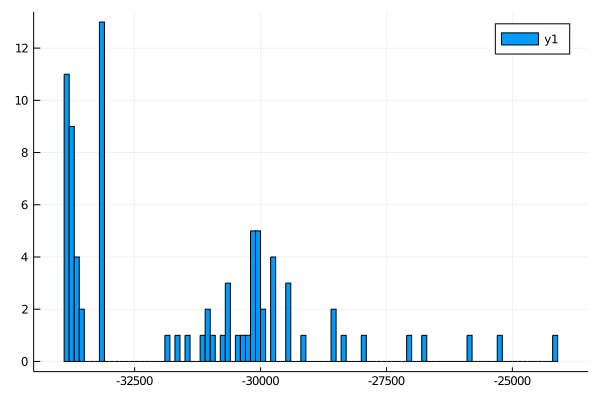

In [294]:
histogram(converged.min, bins=100)

In [295]:
bestpars = converged[findmin(converged.min)[2]].pars

3-element Array{Float64,1}:
  -1.5897639168552422
 -77.58285291980206
  13.615196785687624

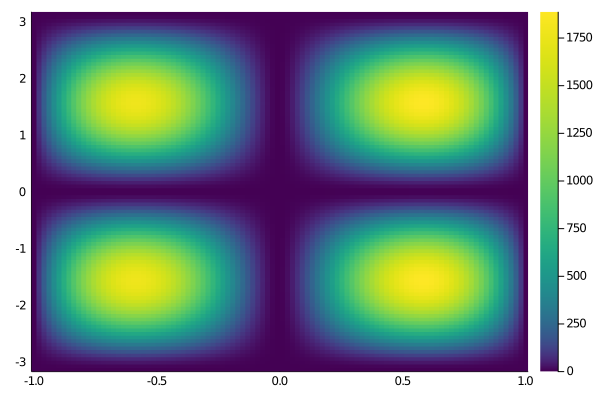

In [296]:
let pars = bestpars
    cosθv = range(-1,1,length=100)
    ϕv = range(-π,π,length=100)
    calv = [model(cosθ,ϕ; pars=pars) for ϕ in ϕv, cosθ in cosθv]
    heatmap(cosθv, ϕv, abs2.(calv), lab="",
        color=cgrad(:viridis, scale=:exp))
end

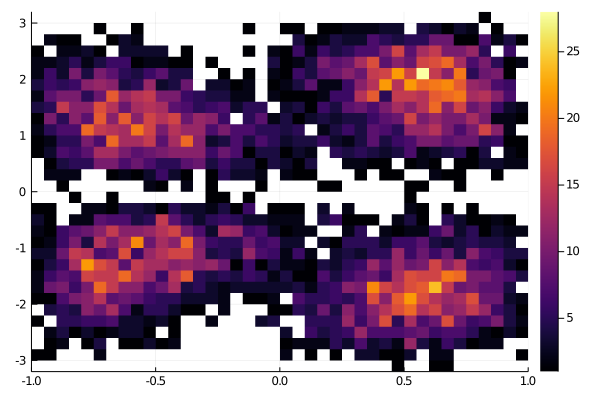

In [297]:
histogram2d(settings["data"].cosθ, settings["data"].ϕ, bins=50)

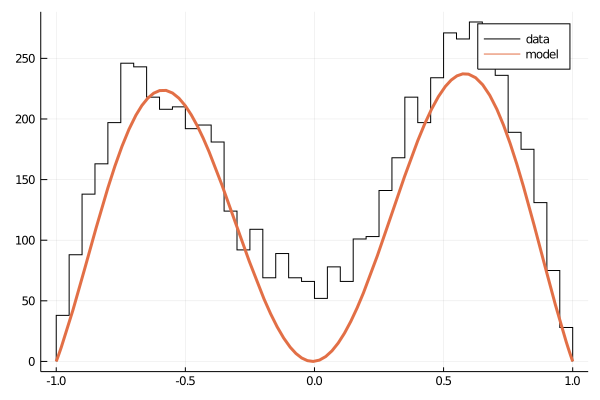

In [298]:
let
    Nd = length(settings["data"])
    Nb = 50
    stephist(settings["data"].cosθ, bins=Nb, lc=:black, lab="data")
    Int(cosθ) = quadgk(ϕ->abs2(model(cosθ,ϕ; pars=bestpars)),-π,π)[1] / Nb * (1+1)
    plot!(Int, -1, 1, lw=3, lab="model")
end